In [1]:
import matplotlib.pyplot as plt
import matplotlib
import itertools
import talib

import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

warnings.filterwarnings("ignore")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#################

train = pd.read_csv('./train.csv')
 
# 추론 결과를 저장하기 위한 dataframe 생성
results_df = pd.DataFrame()

# train 데이터에 존재하는 독립적인 종목코드 추출
unique_codes = train['종목코드'].unique()


# fig, axes = plt.subplots(5,5,figsize =(20,20))
# cnt = 0
## 각 종목코드에 대해서 모델 학습 및 추론 반복
for code in tqdm(unique_codes):
#code = "A103840"

    # 20일선 가격의 상승분과 비교
    train_close = train[train['종목코드'] == code][['일자', '종가', '종목코드']]
    #train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
    train_close.set_index(np.arange(len(train_close)), inplace=True)
    train_close.columns = ['Date', '종가','종목코드']

    w= 20 # 기준 이동평균일 
    k= 2 # 기준 상수

    #중심선 (MBB) : n일 이동평균선
    train_close["mbb"]=train_close["종가"].rolling(w).mean()
    train_close["MA20_std"]=train_close["종가"].rolling(w).std()
    
    #상한선 (UBB) : 중심선 + (표준편차 × K)
    #하한선 (LBB) : 중심선 - (표준편차 × K)
    train_close["ubb"]=train_close.apply(lambda x: x["mbb"]+k*x["MA20_std"],1)
    train_close["lbb"]=train_close.apply(lambda x: x["mbb"]-k*x["MA20_std"],1)
    
    # train_close[['종가','mbb', 'ubb', 'lbb']][-200:].plot.line()
    
    #train_close[["mbb","MA20_std","ubb","lbb"]].fillna(0, inplace=True)
    train_close["percent"] = pd.Series(map(lambda x, y, z: (z-y)/(x-y)*100 if (x-y)>0 else -1 , train_close["ubb"], train_close["lbb"], train_close["종가"]))
    
    # x = train_close["percent"].iloc[20:]
    # y = train_close["종가"].iloc[20:]
    # p = range(0, 5)
    # d = range(0, 5)
    # pdq = list(itertools.product(p, d))
    # axes[pdq[cnt][0], pdq[cnt][1]].scatter(x, y)
    # cnt += 1


    tc = train_close["percent"]

    model = ARIMA(tc, order=(2, 1, 2))
    model.initialize_approximate_diffuse() 
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=15) # 향후 15개의 거래일에 대해서 예측

    # 최종 수익률 계산: 높은데 예측이 오르면 올라가는 걸로, 높은데 예측이 내리면 내리는 것으로, 낮은데 예측이 내리면 내리는 것으로, 낮은데 예측이 오르면 오르는 것으로  
    # final_return = (predictions.iloc[-1] - predictions.iloc[0])*abs(predictions.iloc[0])
    # 밑에서 올라가는 것에 가중치: 밑에서 올라가는 것(가중치 최고), 밑에서 내려가는것(가중치 중하), 위에서 올라가는 것(가중치 중상), 위에서 내려가는 것(가중치 최저)
    final_return = predictions.iloc[-1]-2*predictions.iloc[0] # 변동폭-첫 예측값을 뺀다. 처음값이 높으면 하락할 가능성이 높다.

    


    # 결과 저장
    results_df = results_df.append({'종목코드': code, 'final_return': final_return}, ignore_index=True)


# +로 계속 유지되는것으로 예측되면 순위를 낮추기

# p = range(0, 5)
# d = range(0, 5)
# q = range(0, 5)
# pdq = list(itertools.product(p, d, q))

# AIC = []
# aic = {}
# for i in pdq :
#     model = ARIMA(tc, order=(i))
#     model_fit = model.fit()
#     print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
#     AIC.append(round(model_fit.aic, 2))
#     aic[round(model_fit.aic, 2)] = i

# min(aic)

results_df['final_return'] = results_df['final_return'].fillna(0)
results_df['순위'] = results_df['final_return'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df = results_df.sort_values(by='순위')
sample_submission = pd.read_csv('./sample_submission.csv')
baseline_submission = sample_submission[['종목코드']].merge(results_df[['종목코드', '순위']], on='종목코드', how='right')
baseline_submission.to_csv('0725test_submission.csv', index=False)


100%|██████████| 2000/2000 [18:17<00:00,  1.82it/s]


In [3]:
predictions

494    148.033985
495    137.250131
496    125.295523
497    114.355743
498    104.795359
499     96.546854
500     89.456518
501     83.368320
502     78.142275
503     73.656709
504     69.806809
505     66.502519
506     63.666521
507     61.232450
508     59.143343
Name: predicted_mean, dtype: float64

In [5]:
results_df['final_return'] = results_df['final_return'].fillna(0)
results_df['final_return'] = abs(results_df['final_return'])
results_df['순위'] = results_df['final_return'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df = results_df.sort_values(by='순위')
results_df =  results_df.reset_index()
sample_submission = pd.read_csv('./sample_submission.csv')
baseline_submission = sample_submission[['종목코드']].merge(results_df[['종목코드', '순위']], on='종목코드', how='left')
baseline_submission.to_csv('0726_2_Boll_test_submission.csv', index=False)

ValueError: cannot insert level_0, already exists

In [26]:
results_df = pd.read_csv('0726test_submission.csv')
results_df = results_df.sort_values(by='순위')
sample_submission = pd.read_csv('./sample_submission.csv')
baseline_submission = sample_submission[['종목코드']].merge(results_df[['종목코드', '순위']], on='종목코드', how='right')
baseline_submission.to_csv('0726_2_boll_test_submission.csv', index=False)

In [27]:
results_df

,종목코드,순위
1803,A270520,1
156,A003520,2
1609,A206400,3
939,A056090,4
579,A025560,5
...,...,...
1057,A069110,1996
1920,A318020,1997
948,A057880,1998
645,A032860,1999


<Axes: >

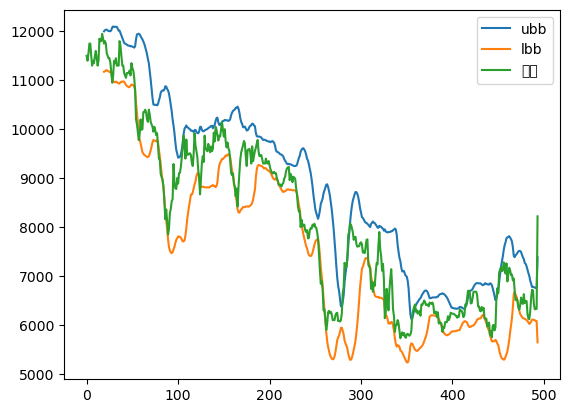

In [26]:
train_close[['ubb','lbb','종가']].plot.line(subplots=False)

In [2]:
import pandas as pd
test1 = pd.read_csv('./0722_9test_submission.csv')
test2= pd.read_csv('./base_submission_JE.csv')

rank = []
for code in tqdm(unique_codes):
    rank.append(test1[test1["종목코드"] == code]*(2001-x)*0.70*0.874 + test2[test2["종목코드"]==code]*0.443*0.874, code)

result = pd.DataFrame(rank, columns = ["종목코드", "순위"])   
    
    
    


result['순위'] = result['기울기'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
result = result.sort_values(by='순위')
result.to_csv('./stock_data/0721result.csv', encoding='euc-kr')

sample_submission = pd.read_csv('./sample_submission.csv')
baseline_submission = sample_submission[['종목코드']].merge(result[['종목코드', '순위']], on='종목코드', how='right')
baseline_submission.to_csv('0722_11test_submission.csv', index=False)


,종목코드,순위
0,A064520,1
1,A101390,2
2,A123010,3
3,A054180,4
4,A016790,5
...,...,...
1995,A032800,1996
1996,A214270,1997
1997,A093230,1998
1998,A263540,1999


In [18]:
from tqdm import tqdm
import pandas as pd
test1 = pd.read_csv('./0722_9test_submission.csv')
test2= pd.read_csv('./base_submission_JE.csv')
train = pd.read_csv('./train.csv')
unique_codes = train['종목코드'].unique()

rank = []
for code in tqdm(unique_codes):
    rank.append([code, (2001-int(test1[test1["종목코드"] == code]["순위"]))*0.70*0.874 + (2001-int(test2[test2["종목코드"]==code]["순위"]))*0.443*0.874])

result = pd.DataFrame(rank, columns = ["종목코드", "순위"])   
result


result['순위'] = result['순위'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
result = result.sort_values(by='순위')
result.to_csv('./stock_data/0721result.csv', encoding='euc-kr')

sample_submission = pd.read_csv('./sample_submission.csv')
baseline_submission = sample_submission[['종목코드']].merge(result[['종목코드', '순위']], on='종목코드', how='right')
baseline_submission.to_csv('0724test_submission.csv', index=False)

100%|██████████| 2000/2000 [00:01<00:00, 1081.06it/s]


In [14]:
int(test1[test1["종목코드"] == "A183490"]["순위"])

1893